# 📊 Time Series Analysis: Electronics Product Pricing Data

## Overview
This notebook performs comprehensive time series analysis on electronics product pricing data with the goal of understanding discount patterns, detecting seasonality, and preparing data for SARIMA forecasting.

### Analysis Components:
1. **Data Loading and Preprocessing**
2. **Feature Engineering** (discount calculations, temporal features)
3. **Exploratory Data Analysis** (correlations, visualizations)
4. **Seasonality Detection** (monthly and weekly patterns)
5. **Rolling Statistics** (weekly aggregations)
6. **Lag Feature Engineering** (autocorrelation analysis)

### Dataset:
- **Source**: ElectronicsProductsPricingData.csv
- **Time Period**: 2014-2018 (focus on 2017-2018)
- **Key Metric**: Discount percentage over time

---

##  Dataset Loading

This section imports the required libraries and loads the dataset into a pandas DataFrame. The dataset is the foundation for all subsequent preprocessing and analysis steps. We will install all the libraries that we need.

### Library Installation

**Purpose**: Install required Python packages for time series analysis.

**Libraries needed**:
- **`statsmodels`**: Statistical models for time series (ARIMA, SARIMA, ADF test, ACF/PACF)
- **`pandas`**: Data manipulation and analysis with DataFrames
- **`matplotlib`**: Core plotting library for visualizations
- **`seaborn`**: Statistical visualization built on matplotlib

**Installation command**:
```bash
pip install statsmodels pandas matplotlib seaborn
```

**Note**: This cell is commented out because package installation should typically be done via terminal/command prompt, not within the notebook itself. Uncomment only if running in an environment where pip install in cells is appropriate.

In [2]:
## pip install statsmodels pandas matplotlib seaborn

## Loading & Filtering data 

### Load data
Reads a CSV file into a DataFrame.

### Load Dataset and Display Info

**Purpose**: Import necessary libraries, load the electronics pricing dataset, and inspect its structure.

**What this code does**:

1. **Import Core Libraries**:

2. **Load CSV File**:

3. **Display Dataset Information**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose



df = pd.read_csv("./ElectronicsProductsPricingData.csv", encoding='latin1')



df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7249 entries, 0 to 7248
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7249 non-null   object 
 1   prices.amountMax     7249 non-null   float64
 2   prices.amountMin     7249 non-null   float64
 3   prices.availability  7249 non-null   object 
 4   prices.condition     7249 non-null   object 
 5   prices.currency      7249 non-null   object 
 6   prices.dateSeen      7249 non-null   object 
 7   prices.isSale        7249 non-null   bool   
 8   prices.merchant      7249 non-null   object 
 9   prices.shipping      4277 non-null   object 
 10  prices.sourceURLs    7249 non-null   object 
 11  asins                7249 non-null   object 
 12  brand                7249 non-null   object 
 13  categories           7249 non-null   object 
 14  dateAdded            7249 non-null   object 
 15  dateUpdated          7249 non-null   o

### Remove Unnecessary Columns

**Purpose**: Clean the dataset by dropping columns that are not needed for price and discount analysis.

**Columns being removed**:

1. **`Unnamed: 26-30`**: Empty columns likely created during data export
2. **`sourceURLs`**: Web source links (not needed for analysis)
3. **`prices.currency`**: Currency type (assuming all same currency)
4. **`keys`**: Internal database keys
5. **`ean`**: European Article Number (barcode)- it contains 5706
6. **`prices.shipping`**: Shipping costs (focusing on product price only), and it contaims 2972 null values
7. **`manufacturerNumber`**: Manufacturer-specific product codes
8. **`upc`**: Universal Product Code (another barcode standard)
9. **`manufactureer`**- it also contains 4014 missing values 
**Why remove these columns**:
- **Reduces memory**: Smaller dataset is faster to process
- **Improves clarity**: Easier to see relevant columns
- **Focuses analysis**: Only keeps features needed for time series modeling


In [4]:
## df.isnull().sum()

## removing all the unnecessary columns from the dataframe
df.drop(columns=["Unnamed: 26","Unnamed: 27","Unnamed: 28","Unnamed: 29","Unnamed: 30","sourceURLs","prices.currency", "keys","ean","prices.shipping","manufacturerNumber","upc"], inplace=True)
df.head()

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.sourceURLs,asins,brand,categories,dateAdded,dateUpdated,imageURLs,manufacturer,name,primaryCategories,weight
0,AVphzgbJLJeJML43fA0o,104.99,104.99,Yes,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,http://www.bestbuy.com/site/sanus-tv-wall-moun...,B00C78VIUE,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",2015-04-13T12:00:51Z,2018-05-12T18:59:48Z,https://images-na.ssl-images-amazon.com/images...,NaN,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,32.8 pounds
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,In Stock,New,2017-12-14T06:00:00Z,True,Walmart.com,https://www.walmart.com/ip/BOYTONE-BT210FB-BLA...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds
2,AVpgMuGwLJeJML43KY_c,69.00,69.00,In Stock,New,2017-09-08T05:00:00Z,False,Walmart.com,https://www.walmart.com/ip/Boytone-BT-210F-Blu...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds
3,AVpgMuGwLJeJML43KY_c,69.99,69.99,Yes,New,2017-10-10T05:00:00Z,False,Bestbuy.com,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds
4,AVpgMuGwLJeJML43KY_c,66.99,66.99,Yes,New,2017-08-28T07:00:00Z,False,Bestbuy.com,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds


### Calculate Price Difference and Discount Percentage

**Purpose**: Create new features to quantify discounts for each product.

**What this code does**:

1. **Remove rows with missing prices**:

2. **Calculate absolute price difference**:
   
3. **Calculate discount percentage**:
   
4. **Display updated info**:
   

**Why discount percentage matters**:
- **Time series target**: This is the primary metric we'll forecast
- **Comparability**: 20% discount means the same whether on $10 or $1000 item
- **Business relevance**: Reflects actual promotional strategy

In [5]:

##1.2 we will check if the prices amountMax and minAmount is same 
## we have also put a new column discount percentage.

df.dropna(subset=["prices.amountMax", "prices.amountMin"], inplace=True)
df["price_difference"] = df["prices.amountMax"] - df["prices.amountMin"]
df['discount_percent'] = (df['price_difference'] / df['prices.amountMax']) * 100


## 

### Analyze Product ID Distribution

**Purpose**: Identify which products have multiple price entries (good candidates for time series analysis).


**Explanation**:
- `value_counts()`: Counts occurrences of each unique product ID
- Returns a Series sorted by frequency (descending)
- Shows which products appear most often in the dataset

**What the output tells us**:

- **High counts** (e.g., 150+ entries):
  - Product with extensive price history
  - Multiple observations over time
  - **Excellent for time series modeling**
  - Can detect trends and seasonality

- **Medium counts** (e.g., 20-50 entries):
  - Reasonable historical data
  - Sufficient for basic trend analysis

- **Low counts** (e.g., 1-5 entries):
  - Limited history
  - Not suitable for time series modeling
  - May be new products or single observations

**Why this matters**:
- **Product selection**: Helps choose which products to analyze in detail
- **Data richness**: Products with more entries provide better forecasts
- **Time series viability**: Need sufficient data points for SARIMA models


In [6]:
## we will check if the data has unique ids 
df["id"].value_counts()

id
AV1YFZVDvKc47QAVgp7V    59
AVs4jJ0Vnnc1JgDc4w40    53
AVrI3KE1U2_QcyX9O9Iw    52
AVzxqGmivKc47QAVfTIA    45
AVqkH8TtU2_QcyX9O0rJ    45
                        ..
AWBghGZdYSSHbkXws4Zi     1
AVpfM3TL1cnluZ0-gDuQ     1
AVpiMIyE1cnluZ0-K0TA     1
AV7tZTTYYSSHbkXwokf2     1
AVphzgbJLJeJML43fA0o     1
Name: count, Length: 835, dtype: int64

### Filter for Specific Product Case Study

**Purpose**: Focus on one product with rich historical data and filter for sale periods.



1. **Filter by specific product ID**:
2. **Filter for sale items only**:
3. **Display results**:
  

**Why this approach**:

- **Case study methodology**: Deep dive into one product before generalizing
- **Data richness**: This product has sufficient history for analysis
- **Sale focus**: Understand promotional pricing strategy specifically
- **Simpler modeling**: Single product is easier than multi-product aggregation






In [7]:
## checking in the dataframe electronics if there are different products
## from the above category, we have checked if the dataframe has different ids, and then checked how many values each id has, where we found one particular interested one. 


df_id = df[df["id"] == "AV1YFZVDvKc47QAVgp7V"]
df_id = df_id[df_id["prices.isSale"] == True]
df_id.head()


,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.sourceURLs,asins,...,categories,dateAdded,dateUpdated,imageURLs,manufacturer,name,primaryCategories,weight,price_difference,discount_percent
3722,AV1YFZVDvKc47QAVgp7V,125.99,125.99,TRUE,new,2018-05-27T08:00:00Z,True,Bestbuy.com,https://www.bestbuy.com/site/wd-red-4tb-intern...,"B00EHBERSE,B00F0EIKJO",...,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,0.00,0.000000
3750,AV1YFZVDvKc47QAVgp7V,154.99,139.87,In Stock,New,2018-01-18T14:00:00Z,True,Beach Audio Inc,https://www.walmart.com/ip/Western-Digital-WD4...,"B00EHBERSE,B00F0EIKJO",...,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,15.12,9.755468
3755,AV1YFZVDvKc47QAVgp7V,148.59,133.99,In Stock,New,2018-01-10T10:00:00Z,True,Walmart.com,https://www.walmart.com/ip/WD-Red-4TB-NAS-Hard...,"B00EHBERSE,B00F0EIKJO",...,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,14.60,9.825695
3761,AV1YFZVDvKc47QAVgp7V,148.59,140.45,In Stock,New,2017-10-24T23:00:00Z,True,Walmart.com,https://www.walmart.com/ip/4TB-WD-RED-SATA-6GB...,"B00EHBERSE,B00F0EIKJO",...,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,8.14,5.478161


### Date Format and Discount Calculation

Proper date handling is crucial for time series analysis. This section converts string dates to datetime objects and extracts temporal components.

#### Date Parsing and Temporal Feature Engineering

**Purpose**: Convert date strings to datetime objects and extract year components for temporal analysis.

1. **Convert three date columns to datetime format**:
   
   
   **Each date field serves a different purpose**:
   - **`dateSeen`**: When the price was actually observed/scraped
     - Most relevant for understanding consumer-facing prices
     - Best for analyzing real-world pricing trends
   
   - **`dateUpdated`**: When the database record was last modified
     - Shows data freshness
     - May lag behind actual price changes
   
   - **`dateAdded`**: When product first entered the database
     - Useful for understanding product lifecycle
     - Initial pricing analysis
   
   **`errors="coerce"`**: Invalid dates become NaT (Not a Time) instead of raising errors

2. **Extract year from each datetime column**:
  
   - `.dt.year`: Accessor for datetime year component
   - Creates integer columns (2014, 2015, 2016, etc.)
   - Enables easy year-based filtering and grouping

3. **Check year distribution**:
 
   - Shows how many records per year
   - Identifies temporal coverage of dataset
   - Helps decide which years to focus on

4. **Data validation - remove unparseable dates**:
   
5. **Remove redundant original column**:
  
6. **Display cleaned data**:
  

**Why datetime conversion matters**:
- **Enables time-based operations**:
  - Sorting chronologically
  - Resampling (daily → weekly → monthly)
  - Date filtering and slicing
  - Time difference calculations





In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## converting the date columns (which are in strings) to datetime format
df["dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors="coerce")
df["dateUpdated"] = pd.to_datetime(df["dateUpdated"], errors="coerce")
df["dateAdded"] = pd.to_datetime(df["dateAdded"], errors="coerce")

## extracting the year from the date column
df["date_year"] = df["dateSeen"].dt.year
df["updated_year"] = df["dateUpdated"].dt.year
df["added_year"] = df["dateAdded"].dt.year

df["date_year"].value_counts()
# 2. Drop rows where dates couldn't be parsed (Cleaning the dataset)
# This is part of your "Data validation pipeline" milestone 
df = df.dropna(subset=['dateAdded', 'dateUpdated'])

## we delete the column prices.dateSeen 
df.drop(columns=['prices.dateSeen'], inplace=True)



df.head()

/var/folders/st/r78_rxtx0hd_yr_r8qtl08_c0000gn/T/ipykernel_3476/1511600252.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors="coerce")


,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.isSale,prices.merchant,prices.sourceURLs,asins,brand,...,manufacturer,name,primaryCategories,weight,price_difference,discount_percent,dateSeen,date_year,updated_year,added_year
0,AVphzgbJLJeJML43fA0o,104.99,104.99,Yes,New,False,Bestbuy.com,http://www.bestbuy.com/site/sanus-tv-wall-moun...,B00C78VIUE,Sanus,...,NaN,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,32.8 pounds,0.00,0.000000,NaT,NaN,2018,2015
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,In Stock,New,True,Walmart.com,https://www.walmart.com/ip/BOYTONE-BT210FB-BLA...,"B018K251JE,B00VILQKQ8",Boytone,...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds,4.01,5.811594,2017-12-14 06:00:00+00:00,2017.0,2018,2015
2,AVpgMuGwLJeJML43KY_c,69.00,69.00,In Stock,New,False,Walmart.com,https://www.walmart.com/ip/Boytone-BT-210F-Blu...,"B018K251JE,B00VILQKQ8",Boytone,...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds,0.00,0.000000,2017-09-08 05:00:00+00:00,2017.0,2018,2015
3,AVpgMuGwLJeJML43KY_c,69.99,69.99,Yes,New,False,Bestbuy.com,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds,0.00,0.000000,2017-10-10 05:00:00+00:00,2017.0,2018,2015
4,AVpgMuGwLJeJML43KY_c,66.99,66.99,Yes,New,False,Bestbuy.com,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds,0.00,0.000000,2017-08-28 07:00:00+00:00,2017.0,2018,2015


### Seting time index with sorting it with date and discount percent 
since it  is the loading phase , here we will set an index with dateAdded , and sort the index with date also. 

**Purpose** 
 - Lag features depends on the correct order , if the date is not sorted , it will give the price_lag_1 wrong , the rolling averages and discount detection will also be incoreect and inaccurate .
 - the rows are sorted first with dateAdded and then it will sorted with discount percent 

**df_index_dateSeen** - this will be new dataset just for the index 

**What have we done in the data** 
1. we will first create a new dataset, where we will set dateSeen as the new index, we will aslo sort that dataset with dateSeen index and then with discount_percent
2. we will also sort the original datset with dateseen and then with discount_percent

 the reason we have create two different dataset , it is because we cam not use the dateSeen column now, because it is a index


In [9]:
df_index_dateSeen = df.set_index("dateSeen").sort_index()
df_index_dateSeen.sort_values(by=["dateSeen","discount_percent"], inplace=True)
df.sort_values(by=["dateSeen","discount_percent"], inplace=True)


### Check Missing Values and outliners 
here we will check if we have any missing values , missing dates and missing ids ,furthermore , the problem we get is what type og missing values do we have 

**Outliners** 
 - sometimes outliers in Price or Discount data can be just as damaging as missing values because they skew your averages and break your machine learning models.
 - we will use the the "rule of thumb" detection(z-score) to find outliners, here we will look for values that are more then 3 S.D away from the mean.
 - we will also visulize the outliners in the dataset, for this boxplots are good , if we see dots very far away from the box , those are our promary targets for removal or correction. 

**Results**
 - we do not have rows that have null dates and null prices values, and if we did have the missing values , we would have used the forward_fill backward_fill and interpolation. 
 - The quickest way to see if you have "impossible" prices or discounts is the .describe() method.
 - since the maxprice was between 0 to 5000 and the minprice was between the 0 to 2500, furthermore for the amountmax and amountmin is both 0 
 - since we also have check if there is any null values in the price.amountMax and price.amountMin and dates , furthermore , we have checked if there was any zero value in the datset , but we did not find any, the minimum value for both priceMax or priceMin
 - furthermore , we have that the maximum percentage was around 80 percent.
 - 




id                        0
prices.amountMax          0
prices.amountMin          0
prices.availability       0
prices.condition          0
prices.isSale             0
prices.merchant           0
prices.sourceURLs         0
asins                     0
brand                     0
categories                0
dateAdded                 0
dateUpdated               0
imageURLs                 0
manufacturer           4014
name                      0
primaryCategories         0
weight                    0
price_difference          0
discount_percent          0
dateSeen               3575
date_year              3575
updated_year              0
added_year                0
dtype: int64
Detected 263 outliers.


<Axes: xlabel='discount_percent'>

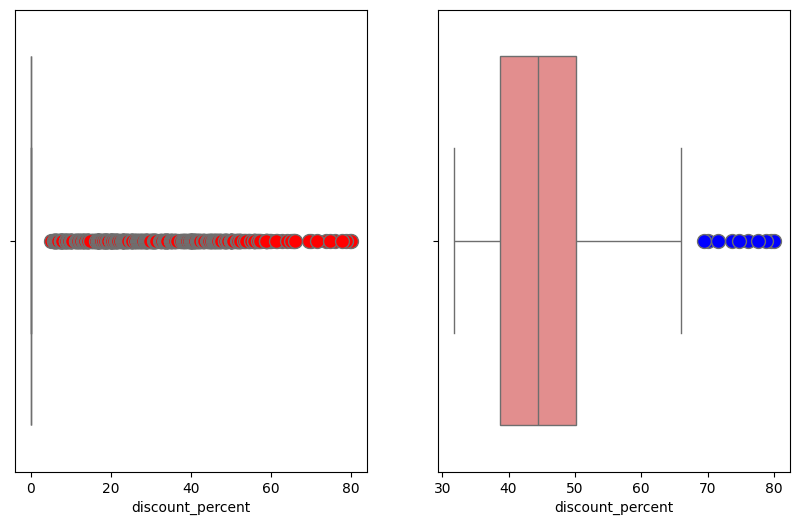

In [10]:
print(df.isnull().sum())

# Simple Z-score logic
mean = df['discount_percent'].mean()
std =  df['discount_percent'].std()

# Anything outside this range is a statistical outlier
upper_limit = mean + (3 * std)
lower_limit = mean - (3 * std)

outliers = df[(df['discount_percent'] > upper_limit) | (df['discount_percent'] < lower_limit)]

print(f"Detected {len(outliers)} outliers.")

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['discount_percent'], color='skyblue',flierprops={'markerfacecolor':'red', 'markersize': 10})



plt.subplot(1, 2, 2)
sns.boxplot(x=outliers['discount_percent'], color='lightcoral',flierprops={'markerfacecolor':'blue', 'markersize': 10})




In [11]:
df.sort_values(by=["dateSeen","discount_percent"], inplace=True,ascending=False) 



##  DATA Visualization 

Comprehensive visualizations to understand pricing patterns, discount trends, and temporal relationships.

### Exploratory Data Analysis: Multi-Dimensional Discount Analysis
To identify price volatility and seasonal discounting cycles, we implemented a 2x2 visualization matrix. This aligns with the Week 3-4 Milestone of performing deep exploratory data analysis (EDA) to justify the transition to predictive modeling.

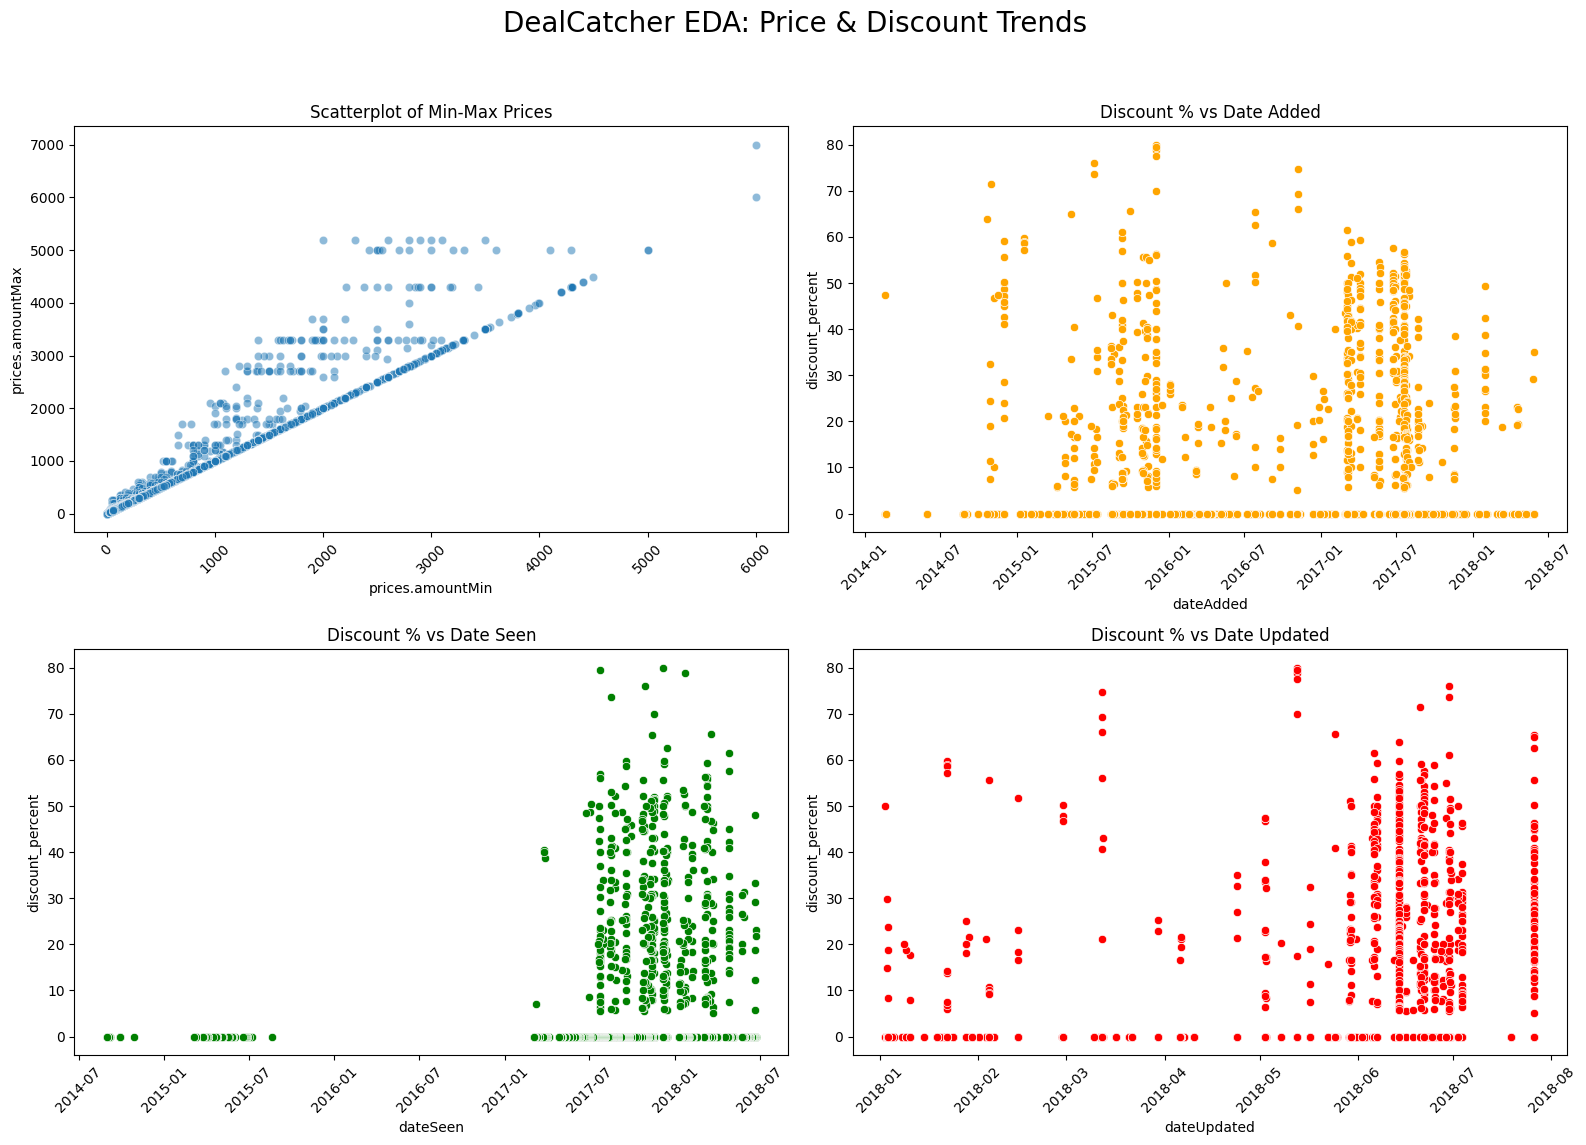

In [12]:
# Create the 2x2 frame
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DealCatcher EDA: Price & Discount Trends', fontsize=20)

# 1. Scatterplot of Min-Max Prices
sns.scatterplot(ax=axes[0, 0], data=df, x='prices.amountMin', y='prices.amountMax', alpha=0.5)
axes[0, 0].set_title('Scatterplot of Min-Max Prices')

# 2. Discount% vs Date Added
sns.scatterplot(ax=axes[0, 1], data=df, x='dateAdded', y='discount_percent', color='orange')
axes[0, 1].set_title('Discount % vs Date Added')

# 3. Discount% vs Date Last Seen
sns.scatterplot(ax=axes[1, 0], data=df, x='dateSeen', y='discount_percent', color='green')
axes[1, 0].set_title('Discount % vs Date Seen')

# 4. Discount% vs Date Updated
sns.scatterplot(ax=axes[1, 1], data=df, x='dateUpdated', y='discount_percent', color='red')
axes[1, 1].set_title('Discount % vs Date Updated')

# Rotate labels so they don't overlap
for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Plot Overall Price Trend

###  Seasonal Discount Analysis (2017-2018)

**Purpose**: Filter data to 2017-2018 and create two plots showing seasonal discount patterns from different date perspectives.

**Part 1: Data Filtering**

**Why filter to 2017-2018?**
- Earlier analysis showed 2014-2015 had sparse data
- 2017-2018 have the highest data density
- Ensures all three date fields are within range
- Focuses on most recent and complete period

**Part 2: Plot 1 - Seasonality by Date Seen**

**What this does**:
- Extracts month (1-12) from dateSeen
- Creates line plot with:
  - X-axis: Months (1=Jan, 12=Dec)
  - Y-axis: Average discount percentage
  - Two lines (one for 2017, one for 2018)
  - `marker="o"`: Circle at each month

**How to interpret**:
- **Peaks**: Months with highest discounts (likely Nov-Dec)
- **Valleys**: Months with lowest discounts (likely Jan-Feb)
- **Line comparison**: Year-over-year consistency


**What this shows**:
 - 1️⃣ Strong early-year discounts in 2018
    - Jan–April 2018 shows high discounts
    - Peak around March (~11%)
    - Then sharp drop in May–June
 - 2️⃣ 2017 shows strong late-year discounts
    - Very low discounts in early 2017
    - Gradual rise from July onward
    - Peak around November (~10%)



**Expected output**: Two line plots showing monthly discount percentage trends with year-over-year comparison

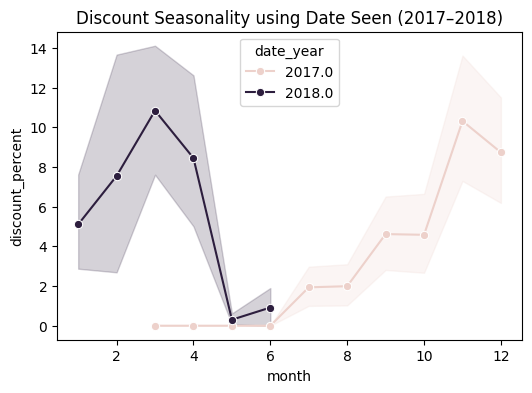

In [13]:
# we will remove the years 2014 and 2015 from the dataset as they have very few data points and we will focus on the years 2017 and 2018 for our seasonality analysis.


## here we will change the data from the electronics dataset to only include the years 2017 and 2018 for the date seen, date updated and date added columns as they have more data points and we will focus on these years for our seasonality analysis.
df = df[df["updated_year"].isin([2017, 2018])]
df = df[df["date_year"].isin([2017, 2018])]
df = df[df["added_year"].isin([2017, 2018])]

df["month"] = df["dateSeen"].dt.month
plt.figure(figsize=(6,4))

sns.lineplot(data=df, x="month", y="discount_percent", hue="date_year", marker="o")
plt.title("Discount Seasonality using Date Seen (2017–2018)")
plt.show()




#### Weekday vs the Weeknd 
This is a feature engineering step. it is modeling step, helps model learn patterns , uses engineered columns , used for prediction , helps  model exploit seasonality.
 - **Results**
- This column contains both 2017 and 2018 data ,, weekdays has more dicsount then the Weeknd ,

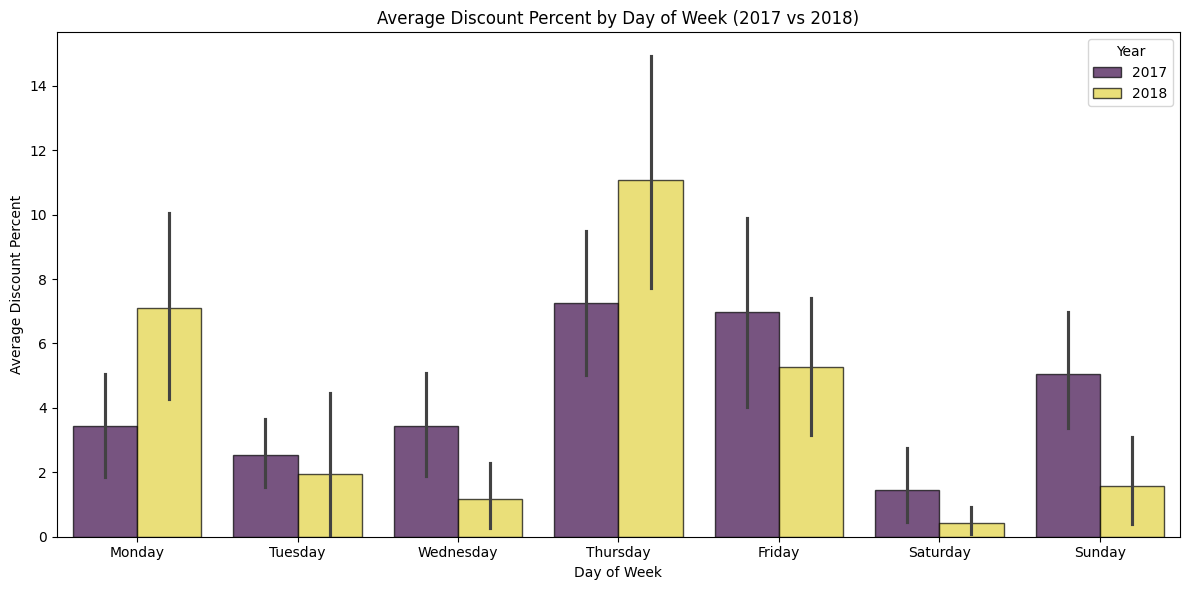

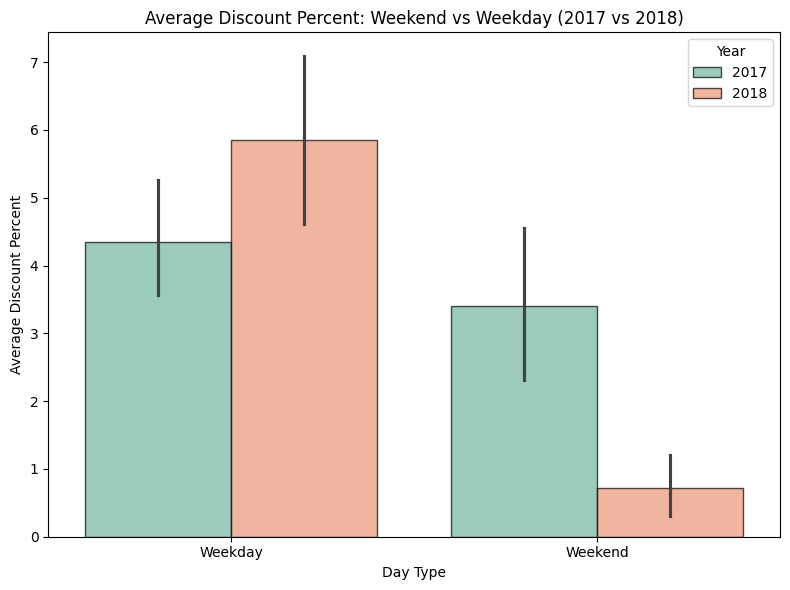

In [14]:
# Extract year and day of week information
df["year"] = df["dateSeen"].dt.year
df["day_of_week"] = df["dateSeen"].dt.day_name()
df["is_weeknd"] = df["day_of_week"].isin(["Saturday", "Sunday"])
df["is_weeknd"] = df["is_weeknd"].replace({True: "Weekend", False: "Weekday"})

# Group by both day and year
df.groupby(["year", "day_of_week"])["discount_percent"].mean()

# Plot 1: Discount by Day of Week - comparing 2017 vs 2018
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df, 
    x="day_of_week", 
    y="discount_percent", 
    hue="year",  # This creates separate bars for each year
    palette="viridis",
    alpha=0.7, 
    edgecolor="black",
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.title("Average Discount Percent by Day of Week (2017 vs 2018)")
plt.xlabel("Day of Week")
plt.ylabel("Average Discount Percent")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

# Plot 2: Weekend vs Weekday - comparing 2017 vs 2018
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df,
    x="is_weeknd", 
    y="discount_percent",
    hue="year",  # This creates separate bars for each year
    palette="Set2", 
    alpha=0.7, 
    edgecolor="black"
)

plt.title("Average Discount Percent: Weekend vs Weekday (2017 vs 2018)")
plt.xlabel("Day Type")
plt.ylabel("Average Discount Percent")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

2.4.2 Discount Seasonality 
 - This is EDA(Exploratory data analysies), furthermore , it is a analytical step , helps you understand data, uses acf , plots no prediction involved , it will answer wether there is seasonlity
 - always 1 (a series is perfectly coorlelated with itself)
 - lag 1 (todays price is stronly corelated to yesterday price)
 - slow decay pattern (the autoccrealtion gradually declines instaed of cutting off quickly), which suggests that series has trend, the series is non-stationary, and prices discount changes slowly over time
 - 

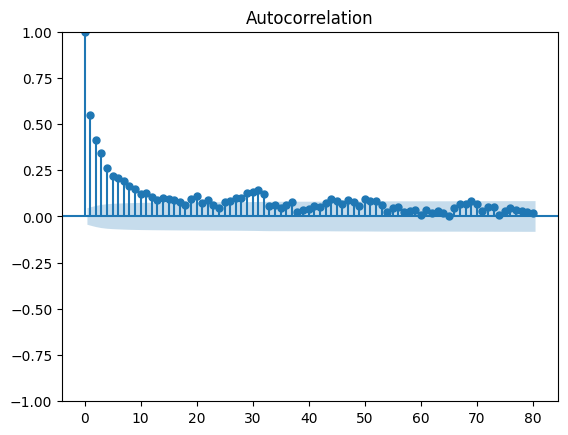

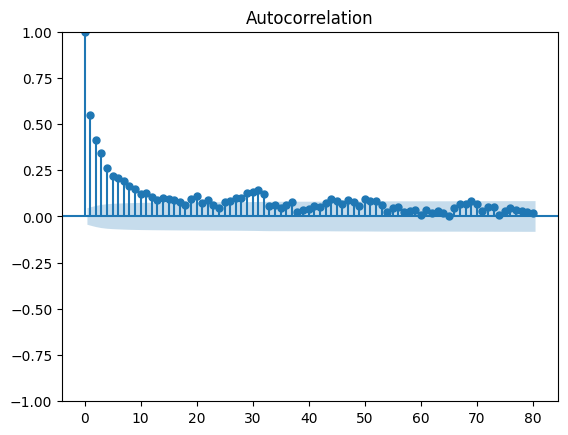

In [15]:

plot_acf(df["discount_percent"], lags=80)


### pacf 
- **Lag 2** - smaller that lag 1 , but clearly outside confidence band.
- After lag 2-3 , values drops near zero, most lags after 3 are very small and within confidence bounds , which is critical.
- 

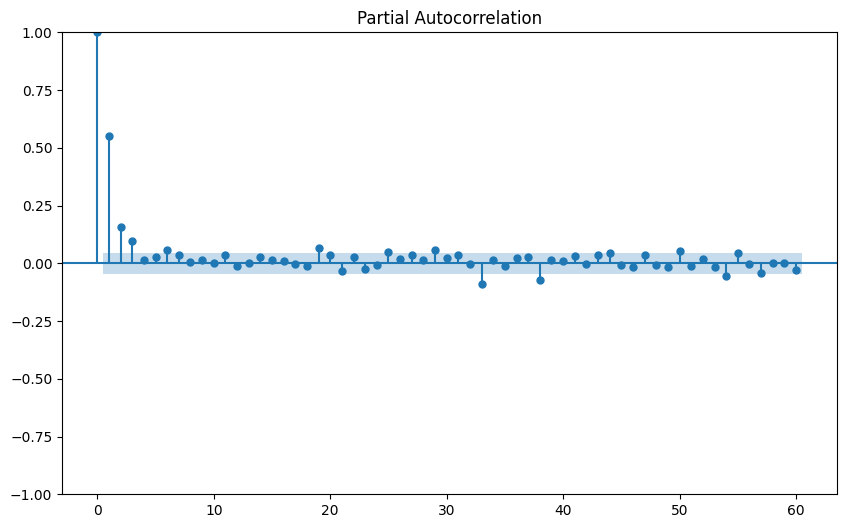

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df["discount_percent"], lags=60, ax=ax)
plt.show()

### AdFuller - for the non-stattionaery 
adfuller - used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

Stationarity implies that the statistical properties of the time series, such as mean and variance, do not change over time.

The test evaluates a null hypothesis that the time series is non-stationary. If the p-value obtained from the test is less than a significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary.
 - null hypothesies 
 - unit root test ( if a time series is non-stationary or not), 
 - here the adf test for unit roots , not general stationarity , 

if the p-value is less then 0.05 , then we reject thr n

In [17]:
df.dropna(subset=["discount_percent"], inplace=True)
result = adfuller(df["discount_percent"].dropna())



print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Lags Used:", result[2])
print("Number of Observations:", result[3])
print("Critical Values:")

for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -10.819015677225236
p-value: 1.8257620939478386e-19
Lags Used: 6
Number of Observations: 1895
Critical Values:
   1%: -3.433805504046101
   5%: -2.8630664092088716
   10%: -2.5675826028083906


### Create Month × Year Pivot Table

**Purpose**: Reorganize data into a pivot table with months as rows and years as columns.

**What this code does**:

1. **Set dateSeen as index and sort chronologically**:
2. **Create pivot table**:


**Parameters explained**:
- `values="discount_percent"`: The metric to aggregate
- `index=...index.month`: Rows = months (1-12)
- `columns=...index.year`: Columns = years (2017, 2018)
- `aggfunc="mean"`: Calculate average discount per cell



**Why this format is useful**:
- **Easy comparison**: See 2017 vs 2018 side-by-side
- **Heatmap ready**: Perfect structure for next visualization
- **Pattern detection**: Scan vertically for seasonal patterns
- **Year-over-year**: Compare horizontally

**Troubleshooting note**:
Comment mentions possible error if `prices.dateSeen` doesn't exist - this is because we already converted it to `dateSeen` in earlier cells.

**Expected output**: A 12×2 table showing average discount percentage for each month in 2017 and 2018

In [18]:


## if you got this error "None of ['prices.dateSeen'] are in the columns"
## then uncomment the above line 
plt.figure(figsize=(12, 6))
df_pivot_table = df.pivot_table(values="discount_percent", index=df_index_dateSeen.index.month, columns=df_index_dateSeen.index.year, aggfunc="mean")
print(df_pivot_table)

ValueError: Grouper and axis must be same length

<Figure size 1200x600 with 0 Axes>

### Heatmap of Monthly Discount Patterns

**Purpose**: Visualize the pivot table as a color-coded heatmap for easy pattern recognition.

**What this code does**:

**Parameters**:
- `df_pivot_table`: The month × year data from previous cell
- `annot=True`: Display discount percentages in each cell
- `cmap="coolwarm"`: Color map
  - **Blue** = Lower discounts (cool colors)
  - **Red** = Higher discounts (warm colors)
  - **White** = Mid-range
- `linewidths=0.5`: Thin white lines separating cells


**Expected patterns**:
- **Red cluster**: November-December (Black Friday, Christmas)
- **Blue cluster**: January-February (post-holiday)
- **Consistent columns**: Similar color progression in both years

**Business insights**:
- **Promotional calendar**: When to plan major sales
- **Inventory planning**: Anticipate discount periods
- **Competitive timing**: Align with industry patterns



In [ ]:
sns.heatmap(df_pivot_table, annot=True, cmap="coolwarm", linewidths=0.5)


## Featuring enginerring pipeline 

### Rolling Statistics

Rolling statistics (moving averages) smooth short-term fluctuations and highlight longer-term trends. Essential for:
- Noise reduction
- Trend identification
- Seasonality detection
- Preparing data for forecasting

### Lag Features 

Lag features represent previous values in a time series. They are crucial for:
- **Autocorrelation analysis**: Understanding temporal dependencies
- **ARIMA/SARIMA modeling**: Determining AR order
- **Machine learning**: Using past to predict future
- **Pattern detection**: Identifying cyclical behavior

#### Lag Features

**Purpose**: Create lagged versions of the discount time series to analyze autocorrelation.

**What this code does**:

1. **Create clean weekly time series**:
- Sets dateSeen as index
- Resamples to weekly frequency
- Calculates average discount per week
- Removes any NaN values
- Creates clean time series `ts`

2. **Initialize lag DataFrame with current values**:
- Creates DataFrame with one column: "current"
- Contains the weekly discount percentages
- This represents time **t** (present)

3. **Create Lag 1 (1 week ago)**:
- `.shift(1)`: Moves all values down by 1 position
- Shows last week's discount
- First value becomes NaN (no previous week)

**Why these specific lags?**
- **Lag 1**: Immediate persistence (AR(1) component)
- **Lag 3**: ~3-week cycles (common in retail)
- **Lag 6**: ~1.5 month patterns
- **Lag 12**: Quarterly cycles (~3 months)

**Purpose of lag features**:
1. **Autocorrelation**: Do past values predict future?
2. **ARIMA order**: Which lags are significant?
3. **Forecasting**: Use historical data as predictors
4. **Pattern detection**: Find cyclical behavior

**Expected output**: DataFrame with 5 columns showing current week and 4 lagged versions, with NaN in early rows

In [19]:

ts = (df_index_dateSeen.resample("D")["discount_percent"].mean()).dropna()
lag_df = pd.DataFrame({"current": ts})

lag_df["lag_1"] = ts.shift(1)
lag_df["lag_12"] = ts.shift(12)
lag_df["lag_14"] = ts.shift(14)
lag_df["lag_30"] = ts.shift(30)

#### Remove Missing Values from Lag Data

**Purpose**: Clean the lag DataFrame by removing rows with NaN values.


**Why this is necessary**:
- The shift() operation creates NaN values:
  - Lag 1: First 1 row has NaN
  - Lag 3: First 3 rows have NaN
  - Lag 12: First 12 rows have NaN
- `dropna()`: Removes rows where ANY column has NaN
- Result: Only complete cases remain

**Impact**:
- Loses first 12 weeks of data (due to lag_12)
- Trade-off: Smaller dataset but complete feature set
- For ~104 weeks (2 years), ~92 usable rows remain

**Why we need complete cases**:
- Required for correlation calculations
- Necessary for scatter plots
- Most models require complete data
- Ensures fair comparison across all lags

**Expected output**: Cleaned lag_df with no NaN values, ready for analysis

In [20]:
lag_df = lag_df.dropna()

#### Lag-1 Autocorrelation Plot

**Purpose**: Visualize the relationship between current discount values and values from 1 week ago.

**What this code does**:

**Components**:
- **Square plot** (6×6): Equal scales for x and y
- **X-axis**: Last week's discount (t-1)
- **Y-axis**: This week's discount (t)
- **Each point**: One week of data

**How to interpret patterns**:

**1. Strong Positive Correlation** (upward diagonal):
```
  High current
       ↑
       |    /
       |   /
       |  /
       | /
       |/________ High lag_1 →
```
- Points cluster along diagonal
- High lag_1 → High current
- **Meaning**: Discounts persist week-to-week
- **SARIMA**: Need AR(1) component

**2. No Correlation** (random cloud):
```
       ↑  • •
       | •  • •
       |  •  •
       |• •   •
       |________ →
```
- Points scattered randomly
- **Meaning**: Last week doesn't predict this week
- **SARIMA**: Try different lags

**3. Negative Correlation** (downward diagonal):
```
       ↑\
       | \
       |  \
       |   \
       |    \
       |________ →
```
- High lag_1 → Low current
- **Meaning**: Alternating pattern
- **Rare** in discount data

**What this tells us**:

- **Strong correlation**: 
  - Discounts are predictable
  - Include AR terms in SARIMA
  - Good 1-week-ahead forecasts possible

- **Weak correlation**:
  - Check other lags (3, 6, 12)
  - May need seasonal components
  - More challenging to forecast



**Expected output**: Scatter plot revealing the strength and direction of week-to-week persistence in discounts

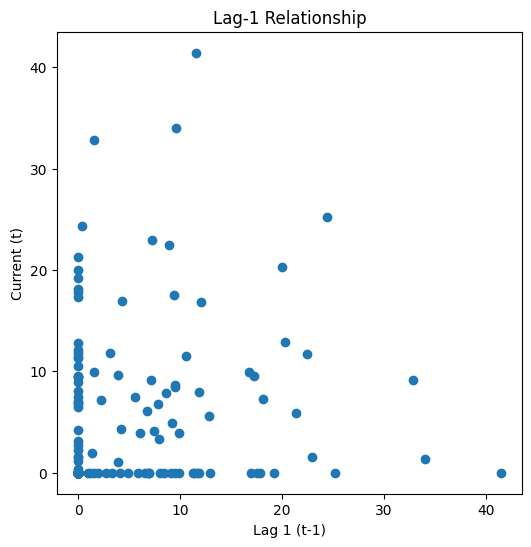

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(lag_df["lag_1"], lag_df["current"])
plt.xlabel("Lag 1 (t-1)")
plt.ylabel("Current (t)")
plt.title("Lag-1 Relationship")
plt.show()

